In [ ]:

# Set up the notebook
%pprint
import sys
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

In [ ]:

from FRVRS import (np, re, nu, nan, fu, isnan, read_excel, osp, display, read_csv)


### Use Pystan to estimate the item logits iteratively for each scene within a calibration process

In [24]:

import pystan
from IPython.display import clear_output

def analyze_data(item_logits, scores):
    """
    Performs Rasch analysis using pystan and updates item logits.

    Args:
        item_logits: Current item logits for each scene.
        scores: Scores for each participant on each scene (0 or 1).

    Returns:
        person_estimates: Estimated ability levels for each participant.
        updated_item_logits: Updated item logits for each scene.
    """

    # Define the Rasch model
    model_code = """
    data {
        int<lower=0> N;  // Number of participants
        int<lower=0> K;  // Number of items
        int<lower=0,upper=1> Y[N, K];  // Observed responses (0 or 1)
    }

    parameters {
        real theta[N];  // Person ability estimates
        real beta[K];  // Item difficulty estimates
    }

    model {
        for (i in 1:N) {
            for (j in 1:K) {
                Y[i, j] ~ bernoulli(exp(theta[i] - beta[j]));
            }
        }
    }
    """

    # Prepare data for Stan
    data = {'N': len(scores), 'K': len(item_logits), 'Y': scores}

    # Initialize Stan model
    sm = pystan.StanModel(model_code=model_code)
    clear_output(wait=True)

    # Fit the model with the current item logits
    try: fit = sm.sampling(data=data, init={'beta': item_logits}, iter=1000)
    except ValueError as e:
        print(str(e).strip())
        fit = sm.sampling(data=data, init='random', iter=1000)

    # Extract person estimates and updated item logits
    person_estimates = fit.extract()['theta']
    updated_item_logits = fit.extract()['beta']

    return person_estimates, updated_item_logits

In [27]:

# Define convergence threshold
threshold = 0.001

# Initialize item logits and scores
item_logits = np.array([correct_stills_logodds, correct_walkers_logodds, correct_wave_logodds, correct_walk_logodds])
columns_list = ['is_stills_visited_first', 'is_walkers_visited_last', 'is_wave_command_issued', 'is_walk_command_issued']
assert len(item_logits) == len(columns_list), 'The item logits need to be the same count as the number of columns in scores'
scores = item_logits_df[columns_list].values

# Find the minimum and maximum values
min_value = np.min(item_logits)
max_value = np.max(item_logits)

# Normalize the values
item_logits = (item_logits - min_value) / (max_value - min_value)

# Define the number of iterations
iterations = 100

for _ in range(iterations):
    # Perform Rasch analysis using the current item logits
    # (This can be done using specialized software or libraries)
    person_estimates, updated_item_logits = analyze_data(item_logits, scores)

    # Check for convergence
    if max(abs(updated_item_logits - item_logits)) <= threshold:
        break

    # Update item logits for the next iteration
    item_logits = updated_item_logits

Invalid specification of initial values.
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: bernoulli_lpmf: Probability parameter is 1.20642, but must be in the interval [0, 1]  (in 'unknown file name' at line 16)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: bernoulli_lpmf: Probability parameter is 4.85385, but must be in the interval [0, 1]  (in 'unknown file name' at line 16)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: bernoulli_lpmf: Probability parameter is 1.25271, but must be in the interval [0, 1]  (in 'unknown file name' at line 16)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: bernoulli_lpmf: Probability parameter is 21.2679, but must be in the interval [0, 1]  (in 'unknown file name' at line 16)

Rejecting initial value:
  Error evaluating the log probability at the initial 

RuntimeError: Initialization failed.

array([-1.00809828, -0.26372883,  1.36712445,  3.2162056 ])


## Determine how to access tasks in the VR logs

### Tools

In [4]:

search_regex = re.compile('needle|decomp', re.IGNORECASE)
columns_list = [cn for cn in nu.get_regexed_columns(frvrs_logs_df, search_regex=search_regex) if not ('voice' in cn)]
print(columns_list)

['injury_record_required_procedure', 'tool_hover_type', 'tool_selected_type', 'injury_treated_required_procedure', 'tool_applied_type', 'tool_applied_tool_location', 'tool_applied_sender', 'tool_applied_attach_message', 'tool_discarded_type']


In [5]:

id_columns = [cn for cn in frvrs_logs_df.columns if cn.endswith('_id')]
nu.get_regexed_dataframe(frvrs_logs_df, columns_list, search_regex=search_regex)[columns_list+id_columns].dropna(
    axis='columns', how='all'
).sample(8).T

353   \
injury_record_required_procedure                                             NaN   
tool_hover_type                                                              NaN   
tool_selected_type                                                           NaN   
injury_treated_required_procedure                                            NaN   
tool_applied_type                                                         Needle   
tool_applied_tool_location                  cath_needle (UnityEngine.GameObject)   
tool_applied_sender                Needle_Decomp(Clone) (UnityEngine.GameObject)   
tool_applied_attach_message                                  AppliedDecompNeedle   
tool_discarded_type                                                          NaN   
injury_record_id                                                             NaN   
injury_record_patient_id                                                     NaN   
injury_treated_id                                                            NaN   
injury_treated_patient_id                                                    NaN   
scene_id                                                                       1   
patient_id                                                                   NaN   
location_id                                                                  NaN   
injury_id                                                                    NaN   

                                                                            1119  \
injury_record_required_procedure                                             NaN   
tool_hover_type                                                              NaN   
tool_selected_type                                                           NaN   
injury_treated_required_procedure                                            NaN   
tool_applied_type                                                         Needle   
tool_applied_tool_location                  cath_needle (UnityEngine.GameObject)   
tool_applied_sender                Needle_Decomp(Clone) (UnityEngine.GameObject)   
tool_applied_attach_message                                  AppliedDecompNeedle   
tool_discarded_type                                                          NaN   
injury_record_id                                                             NaN   
injury_record_patient_id                                                     NaN   
injury_treated_id                                                            NaN   
injury_treated_patient_id                                                    NaN   
scene_id                                                                       1   
patient_id                                                                   NaN   
location_id                                                                  NaN   
injury_id                                                                    NaN   

                                                                            51    \
injury_record_required_procedure                                             NaN   
tool_hover_type                                                              NaN   
tool_selected_type                                                           NaN   
injury_treated_required_procedure                                            NaN   
tool_applied_type                                                         Needle   
tool_applied_tool_location                  cath_needle (UnityEngine.GameObject)   
tool_applied_sender                Needle_Decomp(Clone) (UnityEngine.GameObject)   
tool_applied_attach_message                                  AppliedDecompNeedle   
tool_discarded_type                                                          NaN   
injury_record_id                                                             NaN   
injury_record_patient_id                                                     NaN   
injury_treated_id                         

In [ ]:

def get_treatment_value(self, patient_df, injury_id, verbose=False):
    """
    0=No Treatment or Wrong Treatment, 1=Correct Treatment
    """
    
    # Get required procedure
    mask_series = (patient_df.injury_id == injury_id) & ~patient_df.injury_record_required_procedure.isnull()
    df = patient_df[mask_series]
    if not df.shape[0]: return nan
    required_procedure = df.injury_record_required_procedure.squeeze()
    
    # Get first attempt
    mask_series = (patient_df.injury_id == injury_id) & ~patient_df.injury_treated_required_procedure.isnull()
    df = patient_df[mask_series]
    if not df.shape[0]: return 0
    first_procedure = df.sort_values(['action_tick']).injury_treated_required_procedure.tolist()[0]
    
    is_injury_treated = int(first_procedure == required_procedure)

    return is_injury_treated


### Tags

In [41]:

search_regex = re.compile('green', re.IGNORECASE)
columns_list = [cn for cn in nu.get_regexed_columns(frvrs_logs_df, search_regex=search_regex) if not ('voice' in cn)]
print(columns_list)

['tag_selected_type', 'tag_applied_type', 'tag_discarded_type']


In [51]:

df = nu.get_regexed_dataframe(frvrs_logs_df, columns_list, search_regex=search_regex)[columns_list+id_columns].dropna(
    axis='columns', how='all'
)
df.sample(min(8, df.shape[0])).T

214               1150         217 
tag_selected_type       green               NaN          NaN
tag_applied_type          NaN               NaN        green
tag_discarded_type        NaN             green          NaN
tag_applied_patient_id    NaN               NaN  Mike_0 Root
scene_id                    0                 1            0
patient_id                NaN               NaN  Mike_0 Root
location_id               NaN  (-1.2, 0.6, 5.3)          NaN

In [ ]:

def get_tag_value(patient_df, verbose=False):
    """
    0=No Tag or Wrong Tag, 1=Correct Tag
    """
    is_tag_correct = fu.get_is_tag_correct(patient_df, verbose=verbose)
    if isnan(is_tag_correct): is_tag_correct = 0
    else: is_tag_correct = int(is_tag_correct)

    return is_tag_correct


### Pulse

In [63]:

search_regex = re.compile('pulse', re.IGNORECASE)
columns_list = [cn for cn in nu.get_regexed_columns(frvrs_logs_df, search_regex=search_regex) if not ('voice' in cn)]
print(columns_list)

['action_type', 'pulse_taken_pulse_name']


In [65]:

# columns_list = ['patient_demoted_pulse', 'patient_engaged_pulse', 'patient_record_pulse']
df = frvrs_logs_df[columns_list].drop_duplicates()
mask_series = ~df.pulse_taken_pulse_name.isnull()
df[mask_series]

action_type pulse_taken_pulse_name
43   PULSE_TAKEN            pulse_faint
62   PULSE_TAKEN           pulse_normal
145  PULSE_TAKEN             pulse_fast
321  PULSE_TAKEN             pulse_none

In [ ]:

def get_pulse_value(self, patient_df, verbose=False):
    """
    0=No Pulse Taken, 1=Pulse Taken
    """
    mask_series = (patient_df.action_type == 'PULSE_TAKEN')
    is_pulse_taken = int(patient_df[mask_series].shape[0] > 0)

    return is_pulse_taken


### Stills first

In [ ]:

def get_stills_value(scene_df, verbose=False):
    """
    0=All Stills not visited first, 1=All Stills visited first
    """
    actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_patient_sort_sequences(scene_df, verbose=verbose)

    # Truncate both sequences to the stills length and compare them
    still_len = len(sort_dict['still'])
    ideal_sequence = ideal_sequence.tolist()[:still_len]
    actual_sequence = actual_sequence.tolist()[:still_len]
    is_stills_visited_first = int(actual_sequence == ideal_sequence)

    return is_stills_visited_first


### Walkers last

In [ ]:

def get_walkers_value(scene_df, verbose=False):
    """
    0=All Walkers not visited last, 1=All Walkers visited last
    """
    actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_patient_sort_sequences(scene_df, verbose=verbose)

    # Truncate both sequences to the walkers length and compare them
    walker_len = len(sort_dict['walker'])
    ideal_sequence = ideal_sequence.tolist()[-walker_len:]
    actual_sequence = actual_sequence.tolist()[-walker_len:]
    is_walkers_visited_last = int(actual_sequence == ideal_sequence)

    return is_walkers_visited_last


### Command to wave

In [70]:

search_regex = re.compile('wave', re.IGNORECASE)
columns_list = [cn for cn in nu.get_regexed_columns(frvrs_logs_df, search_regex=search_regex) if not ('voice' in cn)]
print(columns_list)

['action_type', 'patient_demoted_sort', 'patient_record_sort', 's_a_l_t_wave_if_can_sort_command_text', 's_a_l_t_waved_sort_command_text', 'patient_engaged_sort', 'patient_sort']


In [71]:

df = nu.get_regexed_dataframe(frvrs_logs_df, columns_list, search_regex=search_regex)[columns_list+id_columns].dropna(
    axis='columns', how='all'
)
df.sample(min(8, df.shape[0])).T

33               0    \
action_type                               S_A_L_T_WAVED  PATIENT_DEMOTED   
patient_demoted_sort                                NaN            waver   
patient_record_sort                                 NaN              NaN   
s_a_l_t_wave_if_can_sort_command_text               NaN              NaN   
s_a_l_t_waved_sort_command_text                   waved              NaN   
patient_engaged_sort                                NaN              NaN   
patient_sort                                        NaN            waver   
patient_demoted_patient_id                                  NaN      Mike_1 Root   
patient_record_patient_id                                   NaN              NaN   
s_a_l_t_wave_if_can_patient_id                      NaN              NaN   
s_a_l_t_waved_patient_id                    Mike_0 Root              NaN   
patient_engaged_patient_id                                  NaN              NaN   
scene_id                                              0                0   
patient_id                                  Mike_0 Root      Mike_1 Root   
location_id                            (4.1, 0.0, -2.4)  (2.6, 0.0, 0.1)   

                                                       34               59   \
action_type                            S_A_L_T_WAVE_IF_CAN  PATIENT_ENGAGED   
patient_demoted_sort                                   NaN              NaN   
patient_record_sort                                    NaN              NaN   
s_a_l_t_wave_if_can_sort_command_text            waveIfCan              NaN   
s_a_l_t_waved_sort_command_text                        NaN              NaN   
patient_engaged_sort                                   NaN            waver   
patient_sort                                           NaN            waver   
patient_demoted_patient_id                                     NaN              NaN   
patient_record_patient_id                                      NaN              NaN   
s_a_l_t_wave_if_can_patient_id                 Mike_1 Root              NaN   
s_a_l_t_waved_patient_id                               NaN              NaN   
patient_engaged_patient_id                                     NaN      Mike_1 Root   
scene_id                                                 0                0   
patient_id                                     Mike_1 Root      Mike_1 Root   
location_id                                (2.9, 0.0, 0.1)  (2.9, 0.0, 0.1)   

                                                       32               234  \
action_type                            S_A_L_T_WAVE_IF_CAN  PATIENT_DEMOTED   
patient_demoted_sort                                   NaN            waver   
patient_record_sort                                    NaN              NaN   
s_a_l_t_wave_if_can_sort_command_text            waveIfCan              NaN   
s_a_l_t_waved_sort_command_text                        NaN              NaN   
patient_engaged_sort                                   NaN              NaN   
patient_sort                                           NaN            waver   
patient_demoted_patient_id                                     NaN      Lily_2 Root   
patient_record_patient_id                                      NaN              NaN   
s_a_l_t_wave_if_can_patient_id                 Mike_0 Root              NaN   
s_a_l_t_waved_patient_id                               NaN              NaN   
patient_engaged_patient_id                                     NaN              NaN   
scene_id                                                 0                1   
patient_id                                     Mike_0 Root      Lily_2 Root   
location_id                               (4.1, 0.0, -2.4)  (2.8, 0.0, 4.3)   

                                                   11   
action_type                             PATIENT_RECORD  
patient_demoted_sort                               NaN  
patient_record_sort                              waver  
s_a_l

In [ ]:

def get_wave_value(scene_df, verbose=False):
    """
    0=No Wave Command issued, 1=Wave Command issued
    """
    mask_series = (scene_df.action_type == 'S_A_L_T_WAVE_IF_CAN')
    is_wave_command_issued = int(scene_df[mask_series].shape[0] > 0)

    return is_wave_command_issued


### Command to wave

In [72]:

search_regex = re.compile('walk', re.IGNORECASE)
columns_list = [cn for cn in nu.get_regexed_columns(frvrs_logs_df, search_regex=search_regex) if not ('voice' in cn)]
print(columns_list)

['action_type', 'patient_demoted_sort', 'patient_record_sort', 's_a_l_t_walk_if_can_sort_command_text', 's_a_l_t_walked_sort_command_text', 'patient_engaged_sort', 'patient_sort']


In [73]:

df = nu.get_regexed_dataframe(frvrs_logs_df, columns_list, search_regex=search_regex)[columns_list+id_columns].dropna(
    axis='columns', how='all'
)
df.sample(min(8, df.shape[0])).T

19               9    \
action_type                              S_A_L_T_WALKED   PATIENT_RECORD   
patient_demoted_sort                                NaN              NaN   
patient_record_sort                                 NaN           walker   
s_a_l_t_walk_if_can_sort_command_text               NaN              NaN   
s_a_l_t_walked_sort_command_text                 walked              NaN   
patient_engaged_sort                                NaN              NaN   
patient_sort                                        NaN           walker   
patient_demoted_patient_id                                  NaN              NaN   
patient_record_patient_id                                   NaN      Mike_2 Root   
s_a_l_t_walk_if_can_patient_id                      NaN              NaN   
s_a_l_t_walked_patient_id                   Mike_0 Root              NaN   
patient_engaged_patient_id                                  NaN              NaN   
scene_id                                              0                0   
patient_id                                  Mike_0 Root      Mike_2 Root   
location_id                            (2.6, 0.0, -1.4)  (3.1, 0.0, 2.2)   

                                                    13               1    \
action_type                              PATIENT_RECORD  PATIENT_DEMOTED   
patient_demoted_sort                                NaN           walker   
patient_record_sort                              walker              NaN   
s_a_l_t_walk_if_can_sort_command_text               NaN              NaN   
s_a_l_t_walked_sort_command_text                    NaN              NaN   
patient_engaged_sort                                NaN              NaN   
patient_sort                                     walker           walker   
patient_demoted_patient_id                                  NaN      Mike_2 Root   
patient_record_patient_id                           Mike_0 Root              NaN   
s_a_l_t_walk_if_can_patient_id                      NaN              NaN   
s_a_l_t_walked_patient_id                           NaN              NaN   
patient_engaged_patient_id                                  NaN              NaN   
scene_id                                              0                0   
patient_id                                  Mike_0 Root      Mike_2 Root   
location_id                            (2.6, 0.0, -1.4)  (2.6, 0.0, 2.4)   

                                                   23                140  \
action_type                             S_A_L_T_WALKED   PATIENT_ENGAGED   
patient_demoted_sort                               NaN               NaN   
patient_record_sort                                NaN               NaN   
s_a_l_t_walk_if_can_sort_command_text              NaN               NaN   
s_a_l_t_walked_sort_command_text                walked               NaN   
patient_engaged_sort                               NaN            walker   
patient_sort                                       NaN            walker   
patient_demoted_patient_id                                 NaN               NaN   
patient_record_patient_id                                  NaN               NaN   
s_a_l_t_walk_if_can_patient_id                     NaN               NaN   
s_a_l_t_walked_patient_id                  Mike_2 Root               NaN   
patient_engaged_patient_id                                 NaN       Mike_0 Root   
scene_id                                             0                 0   
patient_id                                 Mike_2 Root       Mike_0 Root   
location_id                            (3.1, 0.0, 2.2)  (4.1, 0.0, -2.4)   

                                                       20   
action_type                            S_A_L_T_WALK_IF_CAN  
patient_demoted_sort                                   NaN  
patient_record_sort                                    NaN  
s_a_l_t_walk_if_can_sort_command_text            walkIfCan  
s_a_l_t_walked_sort_comm

In [ ]:

def get_walk_value(scene_df, verbose=False):
    """
    0=No Walk Command issued, 1=Walk Command issued
    """
    mask_series = (scene_df.action_type == 'S_A_L_T_WALK_IF_CAN')
    is_walk_command_issued = int(scene_df[mask_series].shape[0] > 0)

    return is_walk_command_issued


## Rasch Item Analysis Prelim Results

In [7]:

file_path = osp.abspath('../data/xlsx/Copy of Rasch Item Analysis Prelim Results.xlsx')
print([f'pd.{fn}' for fn in dir(pd) if 'excel' in fn.lower()])
item_analysis_df = read_excel(file_path)
print(item_analysis_df.columns.tolist())
print(item_analysis_df.Values.unique().tolist())
display(item_analysis_df.sort_values('Item Logits/Item Difficulty', ascending=False))

['pd.ExcelFile', 'pd.ExcelWriter', 'pd.read_excel']
['Patient', 'Task', 'Variable Name', 'Values', 'Item Logits/Item Difficulty', 'Model Std Error']
['0=No Treatment or Wrong Treatment, 1=Treatment with Pressure Gauze Wrap', '0=No Treatment or Wrong Treatment, 1=Treatment with Tourniquet', '0=Wrong, 1=Correct', '0=No Treatment or Wrong Treatment, 1=Treatment with Wound Packing', nan, "0=Treat/Wrong, 1=Don't Treat/Correct", '0=No Treatment or Wrong Treatment, 1=Treatment with Needle Decompression']


Patient                      Task    Variable Name  \
0      Mike_7_Root     Treat_Shin_Laceration       TRT_7_CALF   
1      Mike_5_Root    Treat_Thigh_Laceration      TRT_5_THIGH   
2    Gloria_8_Root                 Tag-Green    TAG_8_CORRECT   
3    Gloria_8_Root  Treat_Forearm_Laceration    TRT_8_FOREARM   
4      Lily_2_Root                   Tag-Red    TAG_2_CORRECT   
5    Helga_10_Root                Take-Pulse   PULSE_HELGA_10   
6      Mike_7_Root                Take-Pulse     PULSE_MIKE_7   
7       Bob_9_Root                Take-Pulse      PULSE_BOB_9   
8      Mike_5_Root                Take-Pulse     PULSE_MIKE_5   
9      Gary_1_Root                  Tag-Gray    TAG_1_CORRECT   
11     Mike_5_Root    Treat_Stomach_Puncture       TRT_5_SIDE   
10   Gloria_8_Root                Take-Pulse   PULSE_GLORIA_8   
12  Scene_First_11      Visit_Still_Pt_First      STILL_FIRST   
13  Scene_First_11        Visit_Walkers_Last     WALKERS_LAST   
14     Lily_4_Root    Treat_Stomach_Puncture       TRT_4_SIDE   
15   Gloria_6_Root                Take-Pulse   PULSE_GLORIA_6   
16      Bob_9_Root                 Tag-Green    TAG_9_CORRECT   
17     Mike_7_Root      Treat_Thigh_Puncture      TRT_7_THIGH   
18     Gary_3_Root                   Tag-Red    TAG_3_CORRECT   
19     Lily_2_Root                Take-Pulse     PULSE_LILY_2   
20     Lily_4_Root                   Tag-Red    TAG_4_CORRECT   
21     Mike_7_Root                Tag-Yellow    TAG_7_CORRECT   
22   Gloria_6_Root                Tag-Yellow    TAG_6_CORRECT   
23   Gloria_6_Root       Treat_Calf_Shrapnel       TRT_6_CALF   
24     Lily_4_Root                Take-Pulse     PULSE_LILY_4   
25     Mike_5_Root                   Tag-Red    TAG_5_CORRECT   
26   Helga_10_Root                 Tag-Green   TAG_10_CORRECT   
27      Bob_0_Root                Take-Pulse      PULSE_BOB_0   
28  Scene_First_11        Issue-Wave Command     WAVE_COMMAND   
29     Gary_1_Root                Take-Pulse     PULSE_GARY_1   
30     Gary_3_Root                Take-Pulse     PULSE_GARY_3   
31      Bob_0_Root                 Tag-Black    TAG_0_CORRECT   
32     Lily_2_Root     Treat_Shin_Amputation       TRT_2_SHIN   
33  Scene_First_11        Issue-Walk Command     WALK_COMMAND   
34     Gary_1_Root       Treat_Face_Shrapnel       TRT_1_FACE   
35   Helga_10_Root     Treat_Forehead_Scrape  TRT_10_FOREHEAD   
36      Bob_0_Root      Treat_Chest_Collapse      TRT_0_CHEST   
37      Bob_0_Root       Treat_Face_Shrapnel       TRT_0_FACE   
38      Bob_0_Root     Treat_Shin_Amputation       TRT_0_SHIN   
39      Bob_0_Root    Treat_Stomach_Puncture    TRT_0_STOMACH   
40      Bob_0_Root    Treat_Thigh_Laceration      TRT_0_THIGH   
41      Bob_0_Root    Treat_Wrist_Amputation      TRT_0_WRIST   
42     Gary_3_Root      Treat_Chest_Collapse      TRT_3_CHEST   
43     Gary_9_Root     Treat_Eardrum_Rupture   TRT_9_EARBLEED   

                                               Values  \
0   0=No Treatment or Wrong Treatment, 1=Treatment...   
1   0=No Treatment or Wrong Treatment, 1=Treatment...   
2                                  0=Wrong, 1=Correct   
3   0=No Treatment or Wrong Treatment, 1=Treatment...   
4                                  0=Wrong, 1=Correct   
5                                  0=Wrong, 1=Correct   
6                                  0=Wrong, 1=Correct   
7                                  0=Wrong, 1=Correct   
8                                  0=Wrong, 1=Correct   
9                                  0=Wrong, 1=Correct   
11  0=No Treatment or Wrong Treatment, 1=Treatment...   
10                                 0=Wrong, 1=Correct   
12                                                NaN   
13                                                NaN   
14  0=No Treatment or Wrong Treatment, 1=Treatment...   
15                                 0=Wrong, 1=Correct   
16                                 0=Wrong, 1=Correct   
17  0=No Treatment or Wrong Treatment, 1=Treatment...   
18

In [9]:

for value_pair, value_pair_df in item_analysis_df.groupby(['Values'], dropna=False):
    print(value_pair)
    display(value_pair_df)

0=No Treatment or Wrong Treatment, 1=Treatment with Needle Decompression


Patient                  Task Variable Name  \
42  Gary_3_Root  Treat_Chest_Collapse   TRT_3_CHEST   

                                               Values  \
42  0=No Treatment or Wrong Treatment, 1=Treatment...   

    Item Logits/Item Difficulty  Model Std Error  
42                        -4.47             1.82

0=No Treatment or Wrong Treatment, 1=Treatment with Pressure Gauze Wrap


Patient                      Task  Variable Name  \
0     Mike_7_Root     Treat_Shin_Laceration     TRT_7_CALF   
3   Gloria_8_Root  Treat_Forearm_Laceration  TRT_8_FOREARM   
23  Gloria_6_Root       Treat_Calf_Shrapnel     TRT_6_CALF   

                                               Values  \
0   0=No Treatment or Wrong Treatment, 1=Treatment...   
3   0=No Treatment or Wrong Treatment, 1=Treatment...   
23  0=No Treatment or Wrong Treatment, 1=Treatment...   

    Item Logits/Item Difficulty  Model Std Error  
0                          2.61             0.32  
3                          1.49             0.26  
23                        -0.12             0.30

0=No Treatment or Wrong Treatment, 1=Treatment with Tourniquet


Patient                    Task Variable Name  \
1   Mike_5_Root  Treat_Thigh_Laceration   TRT_5_THIGH   
17  Mike_7_Root    Treat_Thigh_Puncture   TRT_7_THIGH   
32  Lily_2_Root   Treat_Shin_Amputation    TRT_2_SHIN   

                                               Values  \
1   0=No Treatment or Wrong Treatment, 1=Treatment...   
17  0=No Treatment or Wrong Treatment, 1=Treatment...   
32  0=No Treatment or Wrong Treatment, 1=Treatment...   

    Item Logits/Item Difficulty  Model Std Error  
1                          2.51             0.31  
17                         0.22             0.28  
32                        -1.82             0.53

0=No Treatment or Wrong Treatment, 1=Treatment with Wound Packing


Patient                    Task Variable Name  \
11  Mike_5_Root  Treat_Stomach_Puncture    TRT_5_SIDE   
14  Lily_4_Root  Treat_Stomach_Puncture    TRT_4_SIDE   

                                               Values  \
11  0=No Treatment or Wrong Treatment, 1=Treatment...   
14  0=No Treatment or Wrong Treatment, 1=Treatment...   

    Item Logits/Item Difficulty  Model Std Error  
11                         0.66             0.27  
14                         0.52             0.27

0=Treat/Wrong, 1=Don't Treat/Correct


Patient                    Task    Variable Name  \
34    Gary_1_Root     Treat_Face_Shrapnel       TRT_1_FACE   
35  Helga_10_Root   Treat_Forehead_Scrape  TRT_10_FOREHEAD   
36     Bob_0_Root    Treat_Chest_Collapse      TRT_0_CHEST   
37     Bob_0_Root     Treat_Face_Shrapnel       TRT_0_FACE   
38     Bob_0_Root   Treat_Shin_Amputation       TRT_0_SHIN   
39     Bob_0_Root  Treat_Stomach_Puncture    TRT_0_STOMACH   
40     Bob_0_Root  Treat_Thigh_Laceration      TRT_0_THIGH   
41     Bob_0_Root  Treat_Wrist_Amputation      TRT_0_WRIST   
43    Gary_9_Root   Treat_Eardrum_Rupture   TRT_9_EARBLEED   

                                  Values  Item Logits/Item Difficulty  \
34  0=Treat/Wrong, 1=Don't Treat/Correct                        -2.57   
35  0=Treat/Wrong, 1=Don't Treat/Correct                        -3.29   
36  0=Treat/Wrong, 1=Don't Treat/Correct                        -4.47   
37  0=Treat/Wrong, 1=Don't Treat/Correct                        -4.47   
38  0=Treat/Wrong, 1=Don't Treat/Correct                        -4.47   
39  0=Treat/Wrong, 1=Don't Treat/Correct                        -4.47   
40  0=Treat/Wrong, 1=Don't Treat/Correct                        -4.47   
41  0=Treat/Wrong, 1=Don't Treat/Correct                        -4.47   
43  0=Treat/Wrong, 1=Don't Treat/Correct                        -4.47   

    Model Std Error  
34             0.73  
35             1.02  
36             1.82  
37             1.82  
38             1.82  
39             1.82  
40             1.82  
41             1.82  
43             1.82

0=Wrong, 1=Correct


Patient        Task   Variable Name              Values  \
2   Gloria_8_Root   Tag-Green   TAG_8_CORRECT  0=Wrong, 1=Correct   
4     Lily_2_Root     Tag-Red   TAG_2_CORRECT  0=Wrong, 1=Correct   
5   Helga_10_Root  Take-Pulse  PULSE_HELGA_10  0=Wrong, 1=Correct   
6     Mike_7_Root  Take-Pulse    PULSE_MIKE_7  0=Wrong, 1=Correct   
7      Bob_9_Root  Take-Pulse     PULSE_BOB_9  0=Wrong, 1=Correct   
8     Mike_5_Root  Take-Pulse    PULSE_MIKE_5  0=Wrong, 1=Correct   
9     Gary_1_Root    Tag-Gray   TAG_1_CORRECT  0=Wrong, 1=Correct   
10  Gloria_8_Root  Take-Pulse  PULSE_GLORIA_8  0=Wrong, 1=Correct   
15  Gloria_6_Root  Take-Pulse  PULSE_GLORIA_6  0=Wrong, 1=Correct   
16     Bob_9_Root   Tag-Green   TAG_9_CORRECT  0=Wrong, 1=Correct   
18    Gary_3_Root     Tag-Red   TAG_3_CORRECT  0=Wrong, 1=Correct   
19    Lily_2_Root  Take-Pulse    PULSE_LILY_2  0=Wrong, 1=Correct   
20    Lily_4_Root     Tag-Red   TAG_4_CORRECT  0=Wrong, 1=Correct   
21    Mike_7_Root  Tag-Yellow   TAG_7_CORRECT  0=Wrong, 1=Correct   
22  Gloria_6_Root  Tag-Yellow   TAG_6_CORRECT  0=Wrong, 1=Correct   
24    Lily_4_Root  Take-Pulse    PULSE_LILY_4  0=Wrong, 1=Correct   
25    Mike_5_Root     Tag-Red   TAG_5_CORRECT  0=Wrong, 1=Correct   
26  Helga_10_Root   Tag-Green  TAG_10_CORRECT  0=Wrong, 1=Correct   
27     Bob_0_Root  Take-Pulse     PULSE_BOB_0  0=Wrong, 1=Correct   
29    Gary_1_Root  Take-Pulse    PULSE_GARY_1  0=Wrong, 1=Correct   
30    Gary_3_Root  Take-Pulse    PULSE_GARY_3  0=Wrong, 1=Correct   
31     Bob_0_Root   Tag-Black   TAG_0_CORRECT  0=Wrong, 1=Correct   

    Item Logits/Item Difficulty  Model Std Error  
2                          1.70             0.27  
4                          1.21             0.26  
5                          1.08             0.26  
6                          0.87             0.26  
7                          0.80             0.26  
8                          0.80             0.26  
9                          0.74             0.26  
10                         0.66             0.27  
15                         0.45             0.27  
16                         0.22             0.28  
18                         0.14             0.28  
19                         0.06             0.29  
20                         0.06             0.29  
21                         0.06             0.29  
22                        -0.03             0.29  
24                        -0.21             0.31  
25                        -0.21             0.31  
26                        -0.40             0.32  
27                        -1.02             0.39  
29                        -1.57             0.48  
30                        -1.57             0.48  
31                        -1.82             0.53

nan


Patient                  Task Variable Name Values  \
12  Scene_First_11  Visit_Still_Pt_First   STILL_FIRST    NaN   
13  Scene_First_11    Visit_Walkers_Last  WALKERS_LAST    NaN   
28  Scene_First_11    Issue-Wave Command  WAVE_COMMAND    NaN   
33  Scene_First_11    Issue-Walk Command  WALK_COMMAND    NaN   

    Item Logits/Item Difficulty  Model Std Error  
12                         0.53             0.68  
13                         0.53             0.68  
28                        -1.18             0.41  
33                        -2.13             0.60

In [76]:

confusing_tasks_list = []
for task in item_analysis_df.Task.unique():
    mask_series = (item_analysis_df.Task == task)
    comment_list = [str(v) for v in item_analysis_df[mask_series].Values.unique()]
    if len(comment_list) > 1: confusing_tasks_list.append(task)
print(
    f'For a number of these tasks ({nu.conjunctify_nouns(confusing_tasks_list)}),'
    ' the Rasch Item Analysis Prelim Results has different, contradictory, descriptions of what the values mean for different rows.'
)

For a number of these tasks (Treat_Thigh_Laceration, Treat_Stomach_Puncture, Treat_Shin_Amputation, and Treat_Chest_Collapse), the Rasch Item Analysis Prelim Results has different, contradictory, descriptions of what the values mean for different rows.



## Pystan

In [ ]:

import pystan

model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)

In [4]:

y = model.sampling().extract()['y']
y.mean()  # with luck the result will be near 0


Gradient evaluation took 2.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your expectations accordingly!



Iteration:    1 / 2000 [  0%]  (Warmup)
Gradient evaluation took 2.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 1.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)

Gradient evaluation took 2.2e-05 seconds
Iteration:  200 / 2000 [ 10%]  (Warmup)
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%

0.03866522457394183


# Rasch Analysis

In [ ]:

# Import the spelling data, create an `EdstanData` instance, and fit the Rasch model
from edstan_data import EdstanData

spelling = read_csv('../data/csv/spelling.csv')
words = ['infidelity', 'panoramic', 'succumb', 'girder']
ed_1 = EdstanData(response_matrix = spelling[words])
ed_1.fit_model('rasch', iter=200, chains=4)

In [1]:

# https://colab.research.google.com/drive/1dBcpXxHuc9YXv9yGllxlahx585hEmdbn?usp=sharing#scrollTo=2hlI6NEV_kgV

In [2]:

# This function generates an item bank, in case the user cannot provide one
from catsim.cat import generate_item_bank

# Simulation package contains the Simulator and all abstract classes
# from catsim.simulation import *

# Initialization package contains different initial proficiency estimation strategies
# from catsim.initialization import *

# Selection package contains different item selection strategies
# from catsim.selection import *

# Estimation package contains different proficiency estimation methods
# from catsim.estimation import *

# Stopping package contains different stopping criteria for the CAT
# from catsim.stopping import *

import catsim.plot as catplot

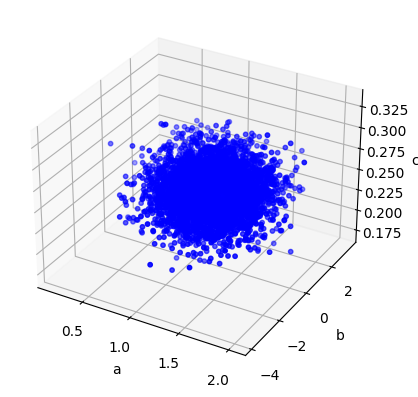

In [4]:

bank_size = 5000
items = generate_item_bank(bank_size, itemtype='3PL')
catplot.gen3d_dataset_scatter(items)

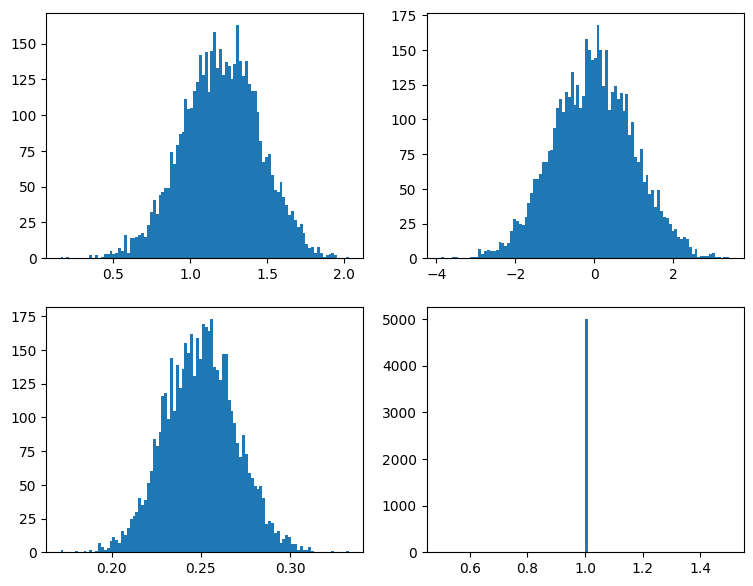

In [5]:

catplot.param_dist(items, figsize=(9, 7))

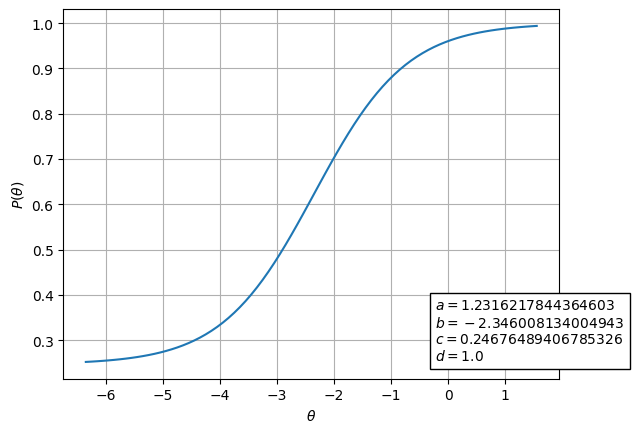

In [6]:

a, b, c, d = items[0]
catplot.item_curve(a,b,c,d)